---
website:
  title: "Introduction to Equivariant Imaging"

format:
  html:
    theme: cosmo
    toc: true
    toc-expand: true
    output-dir: docs
---

# Introduction to Equivariant Imaging

Train a neural network to solve an image inpainting inverse problem, using [perspective-EI](https://arxiv.org/abs/2403.09327) and the [`deepinv`](https://deepinv.github.io/) library.

In [ ]:
import deepinv as dinv

In [1]:
#| code-fold: true
#| code-summary: "`torch` imports"
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize
from torchvision.datasets.utils import download_and_extract_archive

Define inpainting experiment to reconstruct images from images masked with a random mask:

In [4]:
physics = dinv.physics.Inpainting((3, 256, 256), mask=0.6, device="cpu")

Download and load Urban100 dataset of natural urban scenes:

In [4]:
download_and_extract_archive(
    "https://huggingface.co/datasets/eugenesiow/Urban100/resolve/main/data/Urban100_HR.tar.gz?download=true",
    "Urban100",
    filename="Urban100_HR.tar.gz",
    md5="65d9d84a34b72c6f7ca1e26a12df1e4c"
)

100%|██████████| 135388067/135388067 [00:10<00:00, 12603864.84it/s]


Extracting Urban100\Urban100_HR.tar.gz to Urban100


In [5]:
train_dataset, test_dataset = random_split(
    ImageFolder("Urban100", transform=Compose([ToTensor(), Resize(256), CenterCrop(256)])),
    (0.8, 0.2)
    )
    
train_dataloader, test_dataloader = DataLoader(train_dataset, shuffle=True), DataLoader(test_dataset)

As these scenes are imaged with a camera free to move and rotate in the world, we can impose perspective invariance on the unknown image set $x\in X$.

For training, use a small UNet, Adam optimizer, EI loss with homography transform, and the `deepinv.Trainer` functionality:

In [6]:
model = dinv.models.UNet(
    in_channels=3, 
    out_channels=3,
    scales=2,
    circular_padding=True,
    batch_norm=False
)

losses = [
    dinv.loss.MCLoss(), 
    dinv.loss.EILoss(dinv.transform.Homography(theta_max=10))
]

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

Train the model using `deepinv`'s Trainer:

In [7]:
model = dinv.Trainer(
    model=model,
    physics=physics,
    online_measurements=True,
    train_dataloader=train_dataloader,
    eval_dataloader=test_dataloader,
    epochs=1,
    losses=losses,
    optimizer=optimizer,
    verbose=True,
    show_progress_bar=False,
    save_path=None,
    device="cpu"
).train()

The model has 444867 trainable parameters
Eval epoch 0: PSNR=10.078
Train epoch 0: MCLoss=0.002, EILoss=0.021, TotalLoss=0.023, PSNR=15.948


Show results of a pretrained model trained using a larger UNet for 40 epochs:

In [34]:
model = dinv.models.UNet(
    in_channels=3, 
    out_channels=3,
    scales=3,
    circular_padding=True,
    batch_norm=False
)

ckpt = torch.hub.load_state_dict_from_url(
    dinv.models.utils.get_weights_url("ei", "Urban100_inpainting_homography_model.pth"),
    map_location="cpu",
)

model.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

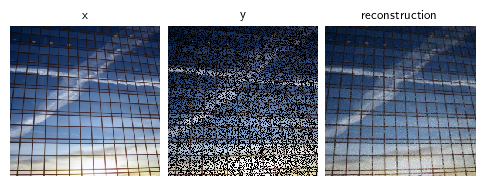

In [35]:
x, _ = next(iter(train_dataloader))
y = physics(x)
x_hat = model(y)

dinv.utils.plot([x, y, x_hat], ["x", "y", "reconstruction"])